In [44]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl
import Integ_analysis as int_analysis
import Transmission_calculation as trans_calc

In [45]:
#Following function plots integration transmission average for parallel observations
def plot_parallel_integ(analysis,guide,aperture_VIS,aperture_NIR,VIS_band,normalise="no AD",method="numerical moffat",
                        aperture="hexagons",sample_val=[1*u.nm,1*u.nm],scale_val=0.01):  
    if VIS_band=="G":
        VIS_band="V"
    weights_VIS = np.arange(0, len(aperture_VIS)+2)
    norm_VIS = mpl.colors.Normalize(vmin=min(weights_VIS), vmax=max(weights_VIS))
    cmap_VIS = mpl.cm.ScalarMappable(norm=norm_VIS, cmap=mpl.cm.Blues)

    weights_NIR = np.arange(0, len(aperture_NIR)+2)
    norm_NIR = mpl.colors.Normalize(vmin=min(weights_NIR), vmax=max(weights_NIR))
    cmap_NIR= mpl.cm.ScalarMappable(norm=norm_NIR, cmap=mpl.cm.Reds)
       
    analysis.load_band("LR","VIS",VIS_band,VIS_band,sampling=sample_val[0])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_VIS,guide)
    print(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_VIS[count]),color=cmap_VIS.to_rgba(len(aperture_VIS)-count))
        plt.plot(analysis.output['wavelengths'],opt_transmission,color='black',linestyle='--')
        
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_VIS[count]),color=cmap_VIS.to_rgba(len(aperture_VIS)-count))

    analysis.load_band("LR","NIR","IY","H",sampling=sample_val[1])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_NIR,guide)
    print(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_NIR.to_rgba(len(aperture_NIR)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output['wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_NIR.to_rgba(len(aperture_NIR)-count))
        plt.axhline(y=1,label='No AD Transmission, {}'.format(analysis.input['method']),color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guide Wavelength = {}'.format(guide))
    #if analysis.input['HA_range'] != []:
        #plt.title("Guide = {}, HA {}-{}, Dec = {}, Centre at = {}h".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec'],analysis.input['HA_range'][analysis.input['centred_on']]))
    plt.legend()

In [46]:
def optimise_parallel(analysis,guide_options,VIS_aperture_centre_options,NIR_aperture_centre_options,VIS_band,scale_val=0.01):
    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    VIS_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,VIS_aperture_centre_options,guide)
        VIS_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    
    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    NIR_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,NIR_aperture_centre_options,guide)
        NIR_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    
    #Need to go through each guide and each permutation of VIS and NIR
    performance_metrics_v1=[]
    performance_metrics_v2=[]
    performance_metrics_v3=[]
    performance_metrics_v4=[]
    for i in range(0,len(guide_options)):
        metric_outer_v1=[]
        metric_outer_v2=[]
        metric_outer_v3=[]
        metric_outer_v4=[]
        for o in range(0,len(VIS_aperture_centre_options)):
            metric_inner_v1=[]
            metric_inner_v2=[]
            metric_inner_v3=[]
            metric_inner_v4=[]
            for p in range(0,len(NIR_aperture_centre_options)):
                VIS_min=VIS_metrics[i][o][0]
                VIS_max=VIS_metrics[i][o][1]
                VIS_throughput=VIS_metrics[i][o][2]
                
                NIR_min=NIR_metrics[i][p][0]
                NIR_max=NIR_metrics[i][p][1]
                NIR_throughput=NIR_metrics[i][p][2]

                metric_v1=(VIS_min/VIS_max)*VIS_throughput*(NIR_min/NIR_max)*NIR_throughput
                metric_v2=(VIS_min/VIS_max)*VIS_throughput**2*(NIR_min/NIR_max)*NIR_throughput**2
                
                metric_v3=(VIS_min)*VIS_throughput*(NIR_min)*NIR_throughput
                metric_v4=(VIS_min)*VIS_throughput**2*(NIR_min)*NIR_throughput**2 
                             
                metric_inner_v1.append(metric_v1)
                metric_inner_v2.append(metric_v2)
                metric_inner_v3.append(metric_v3)
                metric_inner_v4.append(metric_v4)
                
            metric_outer_v1.append(metric_inner_v1)
            metric_outer_v2.append(metric_inner_v2)
            metric_outer_v3.append(metric_inner_v3)
            metric_outer_v4.append(metric_inner_v4)
                       
        performance_metrics_v1.append(metric_outer_v1)
        performance_metrics_v2.append(metric_outer_v2)
        performance_metrics_v3.append(metric_outer_v3)
        performance_metrics_v4.append(metric_outer_v4)
           
    best_metric_v1=0
    best_metric_v2=0
    best_metric_v3=0
    best_metric_v4=0
    for i in range(0,len(guide_options)):
        for o in range(0,len(VIS_aperture_centre_options)):
            for p in range(0,len(NIR_aperture_centre_options)):
                if performance_metrics_v1[i][o][p]>best_metric_v1:
                    best_metric_v1=performance_metrics_v1[i][o][p]
                    best_guide_v1=guide_options[i]
                    best_VIS_aperture_v1=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v1=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v1=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v1=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                    
                if performance_metrics_v2[i][o][p]>best_metric_v2:
                    best_metric_v2=performance_metrics_v2[i][o][p]
                    best_guide_v2=guide_options[i]
                    best_VIS_aperture_v2=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v2=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v2=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v2=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
 
                if performance_metrics_v3[i][o][p]>best_metric_v3:
                    best_metric_v3=performance_metrics_v3[i][o][p]
                    best_guide_v3=guide_options[i]
                    best_VIS_aperture_v3=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v3=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v3=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v3=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                    
                if performance_metrics_v4[i][o][p]>best_metric_v4:
                    best_metric_v4=performance_metrics_v4[i][o][p]
                    best_guide_v4=guide_options[i]
                    best_VIS_aperture_v4=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v4=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v4=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v4=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                          
    best_metric_combo_v1=[best_metric_v1,best_VIS_metrics_v1,best_NIR_metrics_v1]
    best_metric_combo_v2=[best_metric_v2,best_VIS_metrics_v2,best_NIR_metrics_v2]
    best_metric_combo_v3=[best_metric_v3,best_VIS_metrics_v3,best_NIR_metrics_v3]
    best_metric_combo_v4=[best_metric_v4,best_VIS_metrics_v4,best_NIR_metrics_v4]
    
    return [best_guide_v1,best_VIS_aperture_v1,best_NIR_aperture_v1,best_metric_combo_v1],[best_guide_v2,best_VIS_aperture_v2,best_NIR_aperture_v2,best_metric_combo_v2],[best_guide_v3,best_VIS_aperture_v3,best_NIR_aperture_v3,best_metric_combo_v3],[best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4]

In [47]:
# import pandas as pd
# decs = np.arange(-80,25,5)
# HAs = np.arange(0,5,1)
# VIS_bands=["B","G","R"]
# PSFs=['moffat','durham']

# total_decs=[]
# for p in range(0,len(PSFs)):
#     for o in range(0,len(VIS_bands)):
#         for dec in decs:
#             for i in range(0,len(HAs)):         
#                 total_decs.append(dec)
# total_HAs=[]
# for p in range(0,len(PSFs)):
#     for o in range(0,len(VIS_bands)):   
#         for i in range(0,len(decs)):
#             for HA in HAs:
#                 total_HAs.append(HA)
# total_bands=[]
# for p in range(0,len(PSFs)):
#     for band in VIS_bands:
#         for i in range(0,len(decs)):
#             for o in range(0,len(HAs)):
#               total_bands.append(band)
# total_PSFs=[]
# for PSF in PSFs:
#     for o in range(0,len(VIS_bands)):
#         for i in range(0,len(HAs)):
#             for p in range(0,len(decs)):
#                 total_PSFs.append(PSF)  

# data = {'HA mid': total_HAs,'Dec': total_decs,'VIS band': total_bands,'PSF': total_PSFs}
# metrics=pd.DataFrame(data)

# metrics['Guide']=np.nan
# metrics['VIS Centre']=np.nan
# metrics['NIR Centre']=np.nan

# metrics['VIS Min']=np.nan
# metrics['VIS Max']=np.nan
# metrics['VIS Throughput']=np.nan

# metrics['NIR Min']=np.nan
# metrics['NIR Max']=np.nan
# metrics['NIR Throughput']=np.nan

# metrics['Metric']=np.nan

# metrics.to_csv("generic_test_cases_v3.csv",index=False)
# metrics.to_csv("generic_test_cases_v4.csv",index=False)

In [48]:
import pandas as pd
#V boundaries: .6 to 1, .9 to 1.4
#R boundaries: .7 to 1, .9 to 1.4
VIS_B=[.390,.458]
VIS_V=[.450,.591] 
VIS_R=[.586,.770]
NIR_All=[.770,1.857]
#indexes=metrics.loc[(metrics['HA mid']==0) & (metrics['VIS band'] == 'B')].index[0:2]
indexes=np.arange(300,315,1)
for i in indexes:
    metrics=pd.read_csv("generic_test_cases_v1.csv")
    print(i)
    HA_range=np.linspace(metrics.at[i,'HA mid']-0.5,metrics.at[i,'HA mid']+0.5,11)
    targ_dec=metrics.at[i,'Dec']*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v1,v2,v3,v4=optimise_parallel(analysis,np.arange(.7,1,.01)*u.micron,np.arange(VIS_R[0],VIS_R[1],.01)*u.micron,np.arange(.9,1.4,.01)*u.micron,'R',scale_val=0.1)

    best_guide_v1,best_VIS_aperture_v1,best_NIR_aperture_v1,best_metric_combo_v1=v1[0],v1[1],v1[2],v1[3]
    best_guide_v2,best_VIS_aperture_v2,best_NIR_aperture_v2,best_metric_combo_v2=v2[0],v2[1],v2[2],v2[3]
    best_guide_v3,best_VIS_aperture_v3,best_NIR_aperture_v3,best_metric_combo_v3=v3[0],v3[1],v3[2],v3[3]
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]
    
    aperture_VIS_v1=[round(best_VIS_aperture_v1.value,2)]*u.micron
    aperture_NIR_v1=[round(best_NIR_aperture_v1.value,2)]*u.micron
    guide_v1=round(best_guide_v1.value,2)*u.micron

    aperture_VIS_v2=[round(best_VIS_aperture_v2.value,2)]*u.micron
    aperture_NIR_v2=[round(best_NIR_aperture_v2.value,2)]*u.micron
    guide_v2=round(best_guide_v2.value,2)*u.micron
    
    aperture_VIS_v3=[round(best_VIS_aperture_v3.value,2)]*u.micron
    aperture_NIR_v3=[round(best_NIR_aperture_v3.value,2)]*u.micron
    guide_v3=round(best_guide_v3.value,2)*u.micron

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
       
    metrics.at[i,'Guide']=guide_v1.value
    metrics.at[i,'VIS Centre']=aperture_VIS_v1.value
    metrics.at[i,'NIR Centre']=aperture_NIR_v1.value
    metrics.at[i,'VIS Min']=best_metric_combo_v1[1][0]
    metrics.at[i,'VIS Max']=best_metric_combo_v1[1][1]
    metrics.at[i,'VIS Throughput']=best_metric_combo_v1[1][2]
    metrics.at[i,'NIR Min']=best_metric_combo_v1[2][0]
    metrics.at[i,'NIR Max']=best_metric_combo_v1[2][1]
    metrics.at[i,'NIR Throughput']=best_metric_combo_v1[2][2]
    metrics.at[i,'Metric']=best_metric_combo_v1[0]
    metrics.to_csv("generic_test_cases_v1.csv",index=False)
    
    metrics=pd.read_csv("generic_test_cases_v2.csv")
    metrics.at[i,'Guide']=guide_v2.value
    metrics.at[i,'VIS Centre']=aperture_VIS_v2.value
    metrics.at[i,'NIR Centre']=aperture_NIR_v2.value
    metrics.at[i,'VIS Min']=best_metric_combo_v2[1][0]
    metrics.at[i,'VIS Max']=best_metric_combo_v2[1][1]
    metrics.at[i,'VIS Throughput']=best_metric_combo_v2[1][2]
    metrics.at[i,'NIR Min']=best_metric_combo_v2[2][0]
    metrics.at[i,'NIR Max']=best_metric_combo_v2[2][1]
    metrics.at[i,'NIR Throughput']=best_metric_combo_v2[2][2]
    metrics.at[i,'Metric']=best_metric_combo_v2[0]
    metrics.to_csv("generic_test_cases_v2.csv",index=False)

    metrics=pd.read_csv("generic_test_cases_v3.csv")
    metrics.at[i,'Guide']=guide_v3.value
    metrics.at[i,'VIS Centre']=aperture_VIS_v3.value
    metrics.at[i,'NIR Centre']=aperture_NIR_v3.value
    metrics.at[i,'VIS Min']=best_metric_combo_v3[1][0]
    metrics.at[i,'VIS Max']=best_metric_combo_v3[1][1]
    metrics.at[i,'VIS Throughput']=best_metric_combo_v3[1][2]
    metrics.at[i,'NIR Min']=best_metric_combo_v3[2][0]
    metrics.at[i,'NIR Max']=best_metric_combo_v3[2][1]
    metrics.at[i,'NIR Throughput']=best_metric_combo_v3[2][2]
    metrics.at[i,'Metric']=best_metric_combo_v3[0]
    metrics.to_csv("generic_test_cases_v3.csv",index=False)

    metrics=pd.read_csv("generic_test_cases_v4.csv")
    metrics.at[i,'Guide']=guide_v4.value
    metrics.at[i,'VIS Centre']=aperture_VIS_v4.value
    metrics.at[i,'NIR Centre']=aperture_NIR_v4.value
    metrics.at[i,'VIS Min']=best_metric_combo_v4[1][0]
    metrics.at[i,'VIS Max']=best_metric_combo_v4[1][1]
    metrics.at[i,'VIS Throughput']=best_metric_combo_v4[1][2]
    metrics.at[i,'NIR Min']=best_metric_combo_v4[2][0]
    metrics.at[i,'NIR Max']=best_metric_combo_v4[2][1]
    metrics.at[i,'NIR Throughput']=best_metric_combo_v4[2][2]
    metrics.at[i,'Metric']=best_metric_combo_v4[0]
    metrics.to_csv("generic_test_cases_v4.csv",index=False)

300
Target goes below Horizon above/below HA of +/- 5.7h


KeyboardInterrupt: 

Target goes below Horizon above/below HA of +/- 6.6h


Text(0.5, 1.0, 'Dec: -20.0 deg, HA Range: 0.5-1.5h')

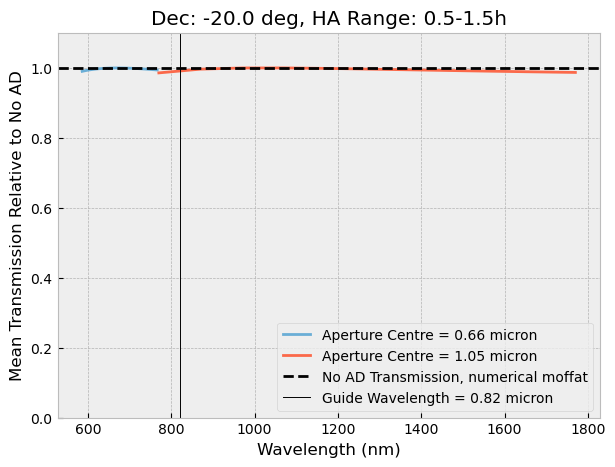

In [ ]:
# alternate metrics; need to make sure one trans isnt sacrified. maybe sum?
# or just use initial guiding/centres, as seems consistent
metrics=pd.read_csv("generic_test_cases_v4.csv")
i=144
#i=24
i=209
i=271
HA_range=np.linspace(metrics.at[i,'HA mid']-0.5,metrics.at[i,'HA mid']+0.5,11)
targ_dec=metrics.at[i,'Dec']*u.deg
guide=metrics.at[i,'Guide']
VIS_centre=metrics.at[i,'VIS Centre']
NIR_centre=metrics.at[i,'NIR Centre']
band=metrics.at[i,'VIS band']

analysis=AD_analysis()
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,guide*u.micron,[VIS_centre]*u.micron,[NIR_centre]*u.micron,band,method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,100*u.nm])
plt.title("Dec: {}, HA Range: {}-{}h".format(targ_dec,HA_range[0],HA_range[-1]))



Target goes below Horizon above/below HA of +/- 6.2h
[[0.779044316609507, 0.9558234189816285, 0.9058707061346002]]
[[0.8091645392933148, 0.9750120796992958, 0.9146170121201536]]
Target goes below Horizon above/below HA of +/- 6.2h
[[0.7884404211078097, 0.9770224227015989, 0.9232956311644496]]
[[0.7985333706782943, 0.9462284525897471, 0.8892914984206806]]


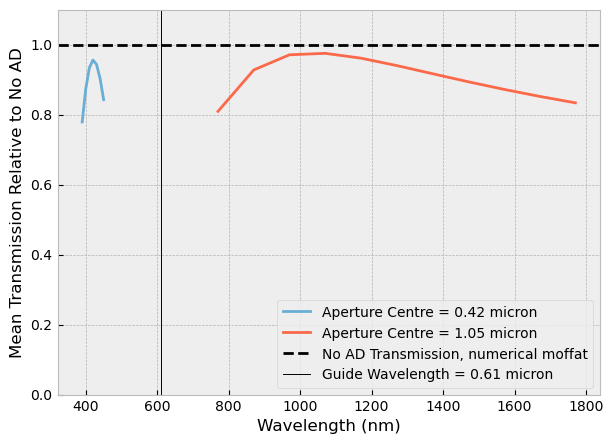

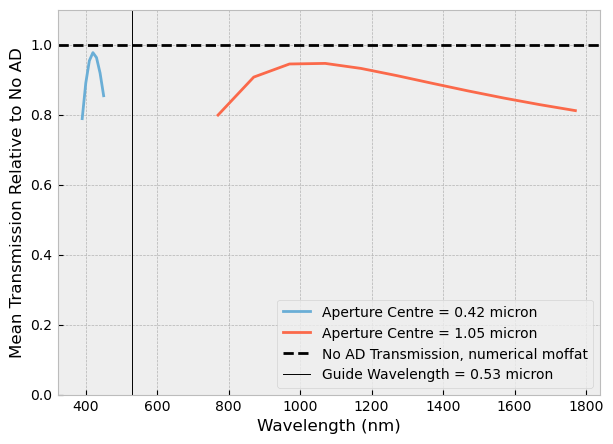

In [ ]:
analysis=AD_analysis()
HA_range=np.linspace(2.5,3.5,21)
targ_dec=-5*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.61*u.micron,[.42]*u.micron,[1.05]*u.micron,"B",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm])

analysis=AD_analysis()
HA_range=np.linspace(2.5,3.5,21)
targ_dec=-5*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.53*u.micron,[.42]*u.micron,[1.05]*u.micron,"B",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm])


Target goes below Horizon above/below HA of +/- 5.5h
Target goes below Horizon above/below HA of +/- 5.5h


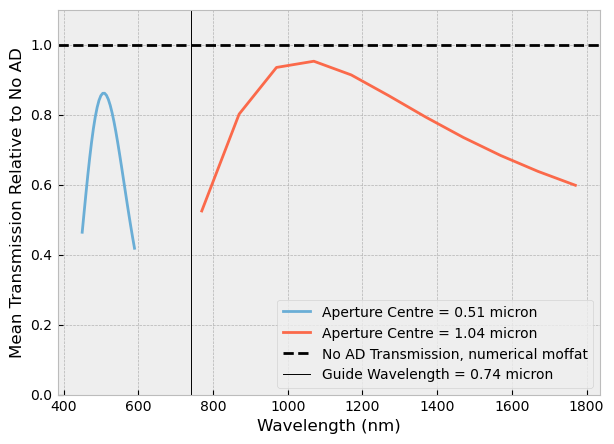

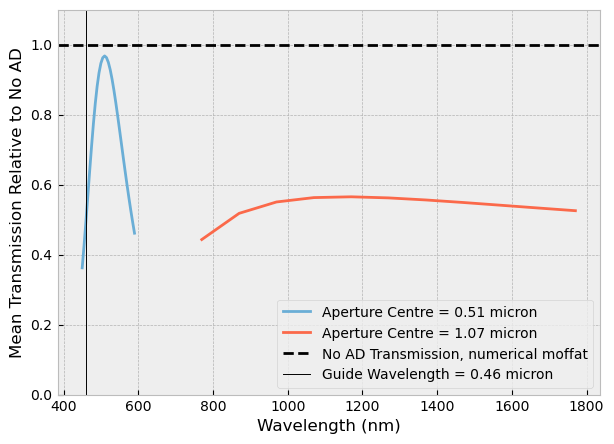

In [ ]:
analysis=AD_analysis()
HA_range=np.linspace(3.5,4.5,21)
targ_dec=15*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.74*u.micron,[.51]*u.micron,[1.04]*u.micron,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,100*u.nm])

analysis=AD_analysis()
HA_range=np.linspace(3.5,4.5,21)
targ_dec=15*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.46*u.micron,[.51]*u.micron,[1.07]*u.micron,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,100*u.nm])



In [ ]:
import pandas as pd
VIS_B=[.390,.458]
VIS_V=[.450,.591] 
VIS_R=[.586,.770]
NIR_All=[.770,1.857]
#indexes=metrics.loc[(metrics['HA mid']==0) & (metrics['VIS band'] == 'B')].index[0:2]
indexes=np.arange(145,315,1)
for i in indexes:
    metrics=pd.read_csv("generic_test_cases_v4.csv")
    print(i)
    HA_range=np.linspace(metrics.at[i,'HA mid']-0.5,metrics.at[i,'HA mid']+0.5,21)
    targ_dec=metrics.at[i,'Dec']*u.deg
    centring="mid HA"
    VIS_band=metrics.at[i,'VIS band']
    VIS_centre=metrics.at[i,'VIS Centre']
    NIR_centre=metrics.at[i,'NIR Centre']
    guide=metrics.at[i,'Guide']
    if VIS_band == "G":
        VIS_band="V"


    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=0.01)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,[VIS_centre]*u.micron,guide*u.micron)
    VIS_metrics=int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all")

    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=0.01)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,[NIR_centre]*u.micron,guide*u.micron)
    NIR_metrics=int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all")
    
    metrics=pd.read_csv("generic_test_cases_final.csv")
    metrics.at[i,'Guide']=guide
    metrics.at[i,'VIS Centre']=VIS_centre
    metrics.at[i,'NIR Centre']=NIR_centre
    metrics.at[i,'VIS Min']=VIS_metrics[0][0]
    metrics.at[i,'VIS Max']=VIS_metrics[0][1]
    metrics.at[i,'VIS Throughput']=VIS_metrics[0][2]
    metrics.at[i,'NIR Min']=NIR_metrics[0][0]
    metrics.at[i,'NIR Max']=NIR_metrics[0][1]
    metrics.at[i,'NIR Throughput']=NIR_metrics[0][2]
    metrics.at[i,'Metric']=NIR_metrics[0][2]**2*NIR_metrics[0][0]*VIS_metrics[0][2]**2*VIS_metrics[0][0]
    metrics.to_csv("generic_test_cases_final.csv",index=False)
  
    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical durham",scale=0.01)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,[VIS_centre]*u.micron,guide*u.micron)
    VIS_metrics=int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all")
    
    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical durham",scale=0.01)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,[NIR_centre]*u.micron,guide*u.micron)
    NIR_metrics=int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all")  
    
    metrics=pd.read_csv("generic_test_cases_final.csv")
    metrics.at[315+i,'Guide']=guide
    metrics.at[315+i,'VIS Centre']=VIS_centre
    metrics.at[315+i,'NIR Centre']=NIR_centre
    metrics.at[315+i,'VIS Min']=VIS_metrics[0][0]
    metrics.at[315+i,'VIS Max']=VIS_metrics[0][1]
    metrics.at[315+i,'VIS Throughput']=VIS_metrics[0][2]
    metrics.at[315+i,'NIR Min']=NIR_metrics[0][0]
    metrics.at[315+i,'NIR Max']=NIR_metrics[0][1]
    metrics.at[315+i,'NIR Throughput']=NIR_metrics[0][2]
    metrics.at[315+i,'Metric']=NIR_metrics[0][2]**2*NIR_metrics[0][0]*VIS_metrics[0][2]**2*VIS_metrics[0][0]
    metrics.to_csv("generic_test_cases_final.csv",index=False)

145
Target goes below Horizon above/below HA of +/- 7.5h
Target goes below Horizon above/below HA of +/- 7.5h
146
Target goes below Horizon above/below HA of +/- 7.5h
Target goes below Horizon above/below HA of +/- 7.5h
147
Target goes below Horizon above/below HA of +/- 7.5h
Target goes below Horizon above/below HA of +/- 7.5h
148
Target goes below Horizon above/below HA of +/- 7.5h
Target goes below Horizon above/below HA of +/- 7.5h
149
Target goes below Horizon above/below HA of +/- 7.5h
Target goes below Horizon above/below HA of +/- 7.5h
150
Target goes below Horizon above/below HA of +/- 7.2h
Target goes below Horizon above/below HA of +/- 7.2h
151
Target goes below Horizon above/below HA of +/- 7.2h
Target goes below Horizon above/below HA of +/- 7.2h
152
Target goes below Horizon above/below HA of +/- 7.2h
Target goes below Horizon above/below HA of +/- 7.2h
153
Target goes below Horizon above/below HA of +/- 7.2h
Target goes below Horizon above/below HA of +/- 7.2h
154
Target

/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/MOSAIC/AD/AD-Code/Main-Version/AD_analysis.py:150: RuntimeWarning: invalid value encountered in arccos
  LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15


211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
Target goes below Horizon above/below HA of +/- 11.3h
Target goes below Horizon above/below HA of +/- 11.3h
226
Target goes below Horizon above/below HA of +/- 11.3h
Target goes below Horizon above/below HA of +/- 11.3h
227
Target goes below Horizon above/below HA of +/- 11.3h
Target goes below Horizon above/below HA of +/- 11.3h
228
Target goes below Horizon above/below HA of +/- 11.3h
Target goes below Horizon above/below HA of +/- 11.3h
229
Target goes below Horizon above/below HA of +/- 11.3h
Target goes below Horizon above/below HA of +/- 11.3h
230
Target goes below Horizon above/below HA of +/- 9.5h
Target goes below Horizon above/below HA of +/- 9.5h
231
Target goes below Horizon above/below HA of +/- 9.5h
Target goes below Horizon above/below HA of +/- 9.5h
232
Target goes below Horizon above/below HA of +/- 9.5h
Target goes below Horizon above/below HA of +/- 9.5h
233
Target goes below Horizon above/below HA of +/- 9.

In [49]:
def optimise_parallel(analysis,guide_options,VIS_aperture_centre_options,NIR_aperture_centre_options,VIS_band,scale_val=0.01):
    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    VIS_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,VIS_aperture_centre_options,guide)
        VIS_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    
    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    NIR_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,NIR_aperture_centre_options,guide)
        NIR_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission),"all"))
    
    #Need to go through each guide and each permutation of VIS and NIR

    performance_metrics_v4=[]
    for i in range(0,len(guide_options)):

        metric_outer_v4=[]
        for o in range(0,len(VIS_aperture_centre_options)):

            metric_inner_v4=[]
            for p in range(0,len(NIR_aperture_centre_options)):
                VIS_min=VIS_metrics[i][o][0]
                VIS_max=VIS_metrics[i][o][1]
                VIS_throughput=VIS_metrics[i][o][2]
                
                NIR_min=NIR_metrics[i][p][0]
                NIR_max=NIR_metrics[i][p][1]
                NIR_throughput=NIR_metrics[i][p][2]


                metric_v4=(VIS_min)*VIS_throughput**2*(NIR_min)*NIR_throughput**2 
                             

                metric_inner_v4.append(metric_v4)
                
     
            metric_outer_v4.append(metric_inner_v4)
                       

        performance_metrics_v4.append(metric_outer_v4)
           

    best_metric_v4=0
    for i in range(0,len(guide_options)):
        for o in range(0,len(VIS_aperture_centre_options)):
            for p in range(0,len(NIR_aperture_centre_options)):
                    
                if performance_metrics_v4[i][o][p]>best_metric_v4:
                    best_metric_v4=performance_metrics_v4[i][o][p]
                    best_guide_v4=guide_options[i]
                    best_VIS_aperture_v4=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v4=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v4=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v4=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                          

    best_metric_combo_v4=[best_metric_v4,best_VIS_metrics_v4,best_NIR_metrics_v4]
    
    return [best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4]

VIS_B=[.390,.458]
VIS_V=[.450,.591] 
VIS_R=[.586,.770]
NIR_All=[.770,1.857]
fields=[2.2,-5.2,-27.8,-60.5,-69.8,-72.8]
HA_mids=0,1,2,3,4
bands=["B","G","R"]

Target goes below Horizon above/below HA of +/- 5.9h
0.67 micron [0.51] micron [1.05] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.9065705213826091, 0.9951770132008136, 0.9705628388690383]]
[[0.9466060021109249, 0.9953906604005163, 0.9755448684785746]]
Target goes below Horizon above/below HA of +/- 5.9h
0.67 micron [0.51] micron [1.05] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.8816277916149541, 0.9943736581690598, 0.9621451705231214]]
[[0.9297136353821592, 0.9946447780473026, 0.9689859269785346]]
Target goes below Horizon above/below HA of +/- 5.9h
0.71 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.8032090231545039, 0.9887037537791286, 0.9324208915673281]]
[[0.8817579246242192, 0.9947139895582953, 0.9483880472831401]]
Target goes below Horizon above/below HA of +/- 5.9h
0.73 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.6787166200702753, 0.97397854148466

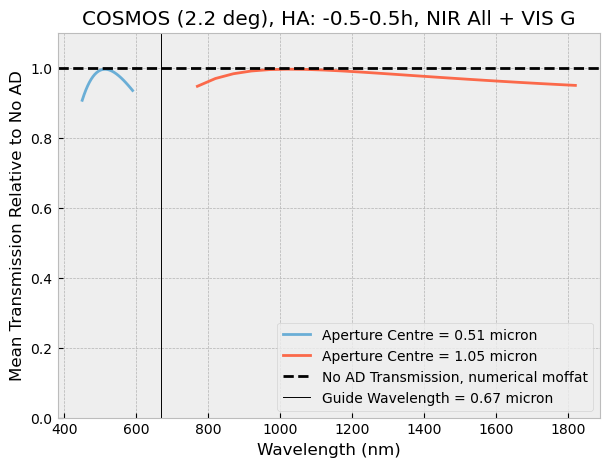

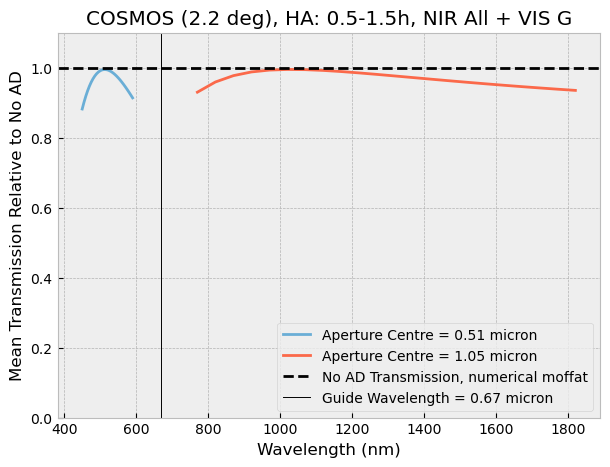

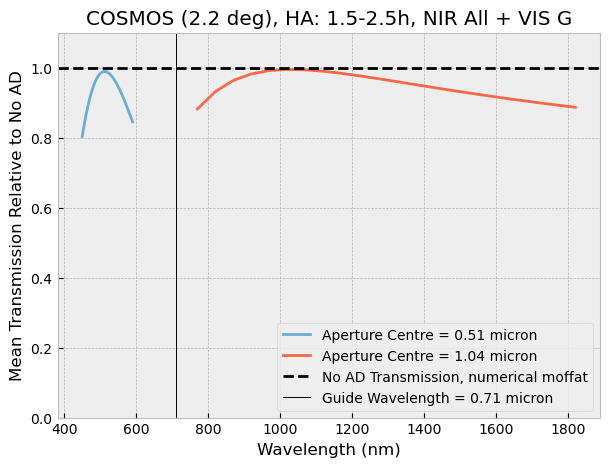

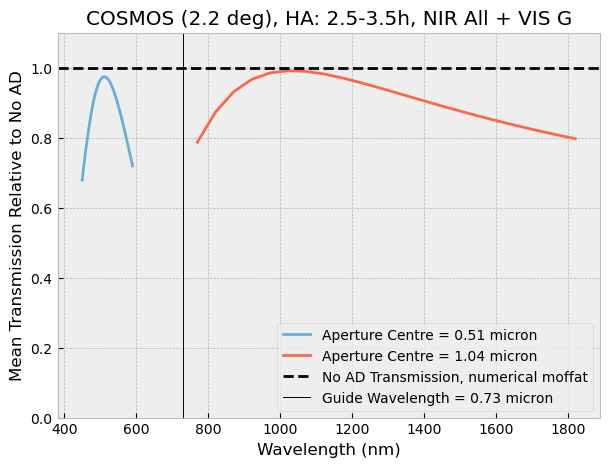

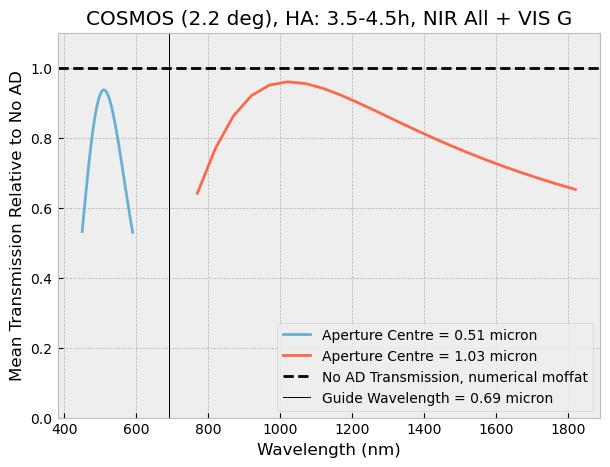

In [65]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[0]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]


    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("COSMOS ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))

    

In [66]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[1]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("UDS ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))


Target goes below Horizon above/below HA of +/- 6.2h


KeyboardInterrupt: 

Target goes below Horizon above/below HA of +/- 6.9h
0.72 micron [0.49] micron [1.19] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9854366609735843, 0.9970283492783336, 0.993667859123703]]
[[0.9931700451518578, 0.998845252731278, 0.995938858544829]]
Target goes below Horizon above/below HA of +/- 6.9h
0.69 micron [0.5] micron [1.1] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9719539482402695, 0.994249175716861, 0.9876773720754566]]
[[0.9832185684911289, 0.9962627499721616, 0.9909827903324407]]
Target goes below Horizon above/below HA of +/- 6.9h
0.68 micron [0.51] micron [1.05] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9067163169887168, 0.9934854390407624, 0.9690133114047722]]
[[0.9452628442870115, 0.9947670126829318, 0.9749546659557218]]
Target goes below Horizon above/below HA of +/- 6.9h
0.7 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.8005626298451334, 0.9873631642879485, 0.9

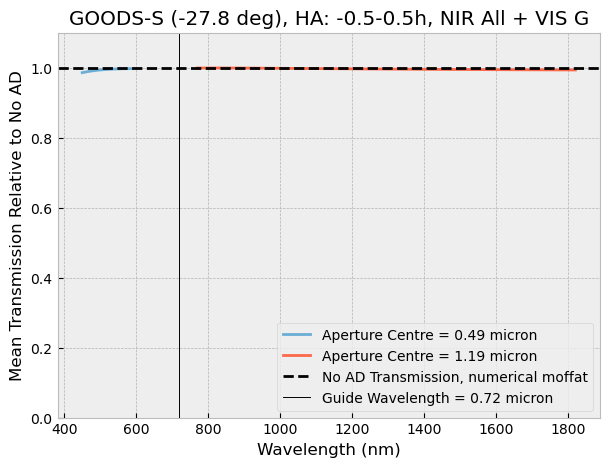

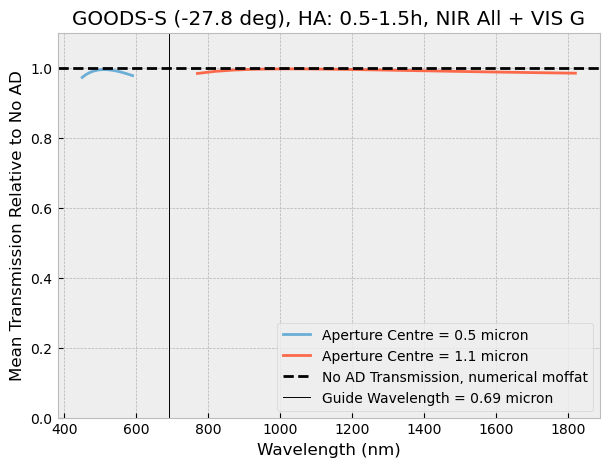

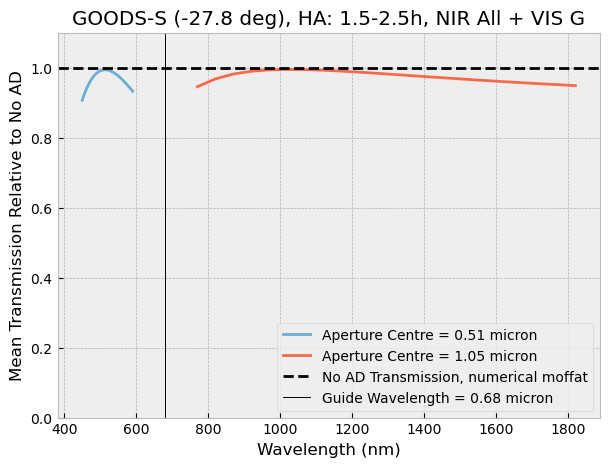

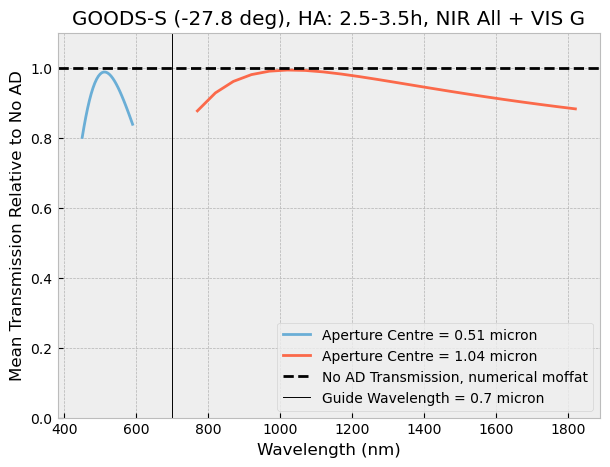

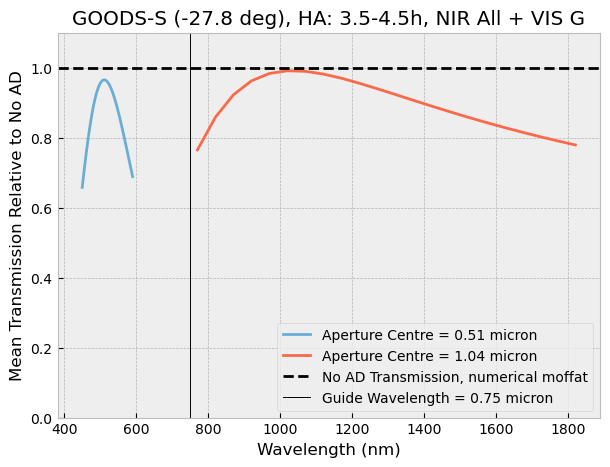

In [67]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[2]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("GOODS-S ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))


Target goes below Horizon above/below HA of +/- 9.6h
0.67 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.8406414395830847, 0.994360063789385, 0.9482757967892732]]
[[0.9041246042509056, 0.994711310090933, 0.957888491610825]]
Target goes below Horizon above/below HA of +/- 9.6h
0.67 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.8274267909108778, 0.994061251689425, 0.9436592016791499]]
[[0.895318155290591, 0.9944177808146875, 0.9541610481815688]]
Target goes below Horizon above/below HA of +/- 9.6h
0.68 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.7872903240510516, 0.9925068665724652, 0.928940421780598]]
[[0.868719512570826, 0.9940620992012938, 0.9432822302120731]]
Target goes below Horizon above/below HA of +/- 9.6h
0.69 micron [0.51] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.7217535519305136, 0.9895624582388353, 0.9

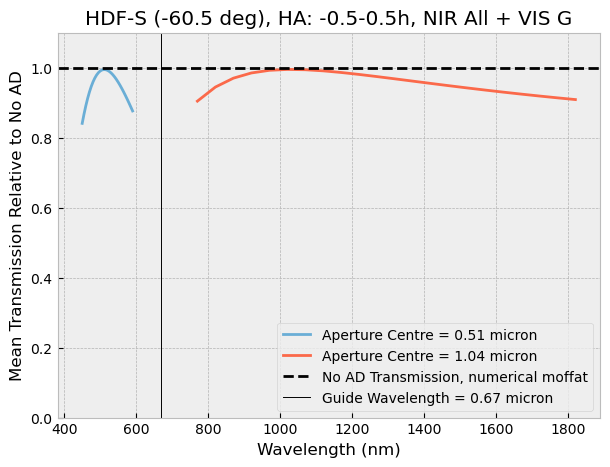

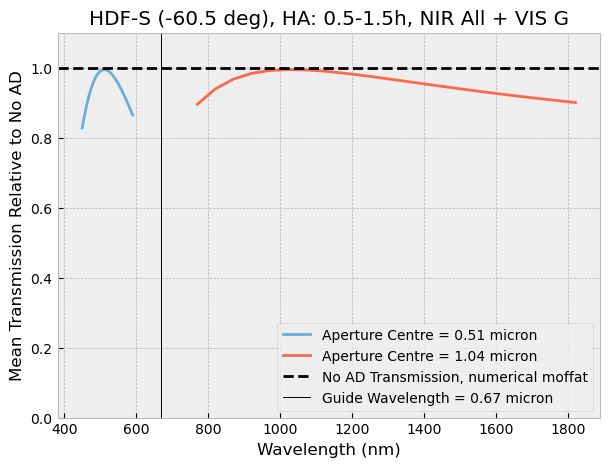

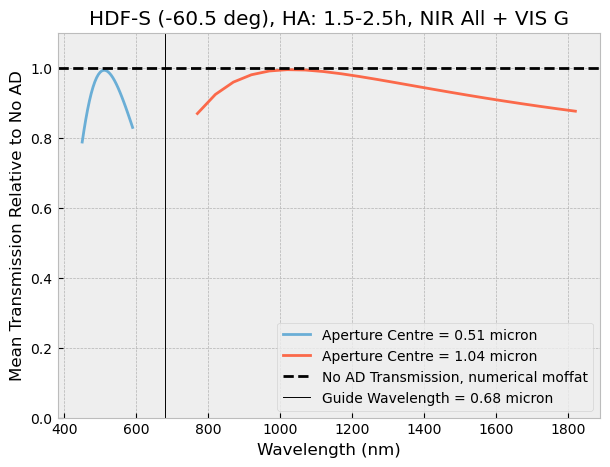

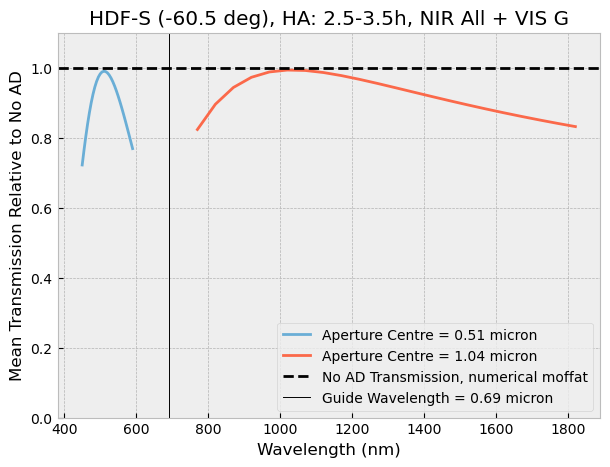

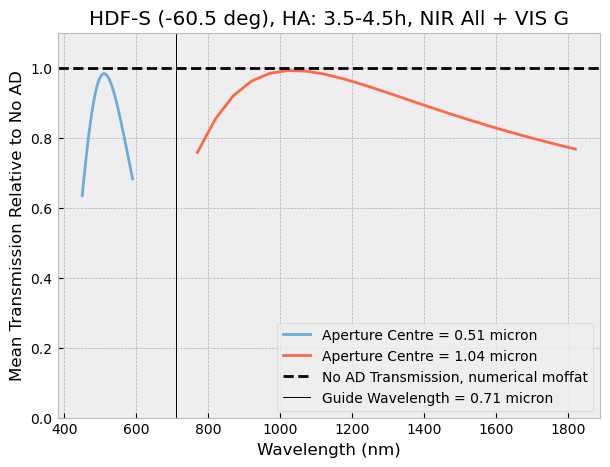

In [69]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[3]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("HDF-S ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))


0.68 micron [0.51] micron [1.04] micron
[[0.7443907148452353, 0.9926443771220143, 0.9140972536639762]]
[[0.8402028424693101, 0.9940868766159767, 0.9314748225287455]]
0.68 micron [0.51] micron [1.04] micron
[[0.7343838486977826, 0.9923730505316388, 0.9102733285592687]]
[[0.8331800610083882, 0.9938610680748506, 0.9283292788648794]]
0.68 micron [0.51] micron [1.04] micron
[[0.7047415593217421, 0.9915020619314426, 0.8986725958491583]]
[[0.8120445277253281, 0.9931381250649155, 0.918731205456596]]
0.7 micron [0.51] micron [1.04] micron
[[0.6558162623158622, 0.9883604969452509, 0.8777686518188682]]
[[0.7772260912363673, 0.9932177236955702, 0.9037988919299231]]
0.74 micron [0.51] micron [1.04] micron
[[0.5909926064600598, 0.9815103775479121, 0.8466607278973038]]
[[0.7287549996475141, 0.9940825396332671, 0.8828746338258449]]


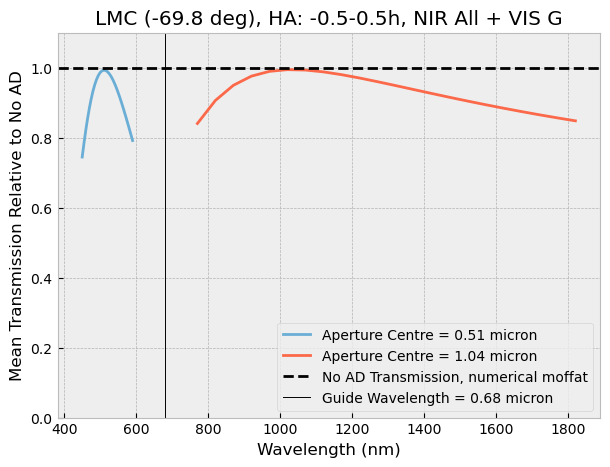

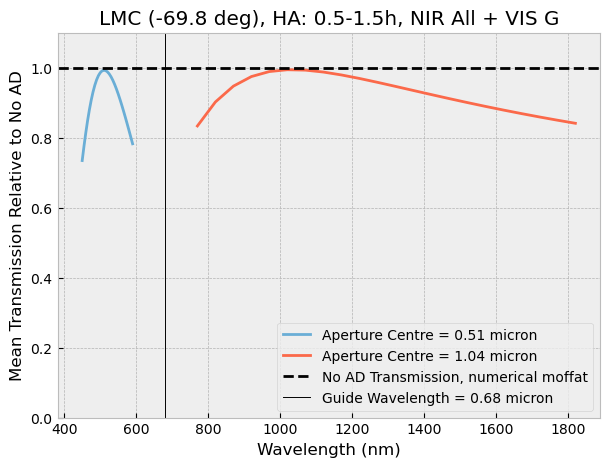

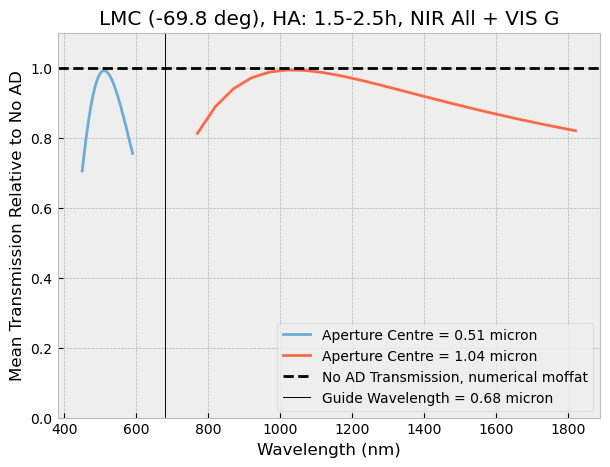

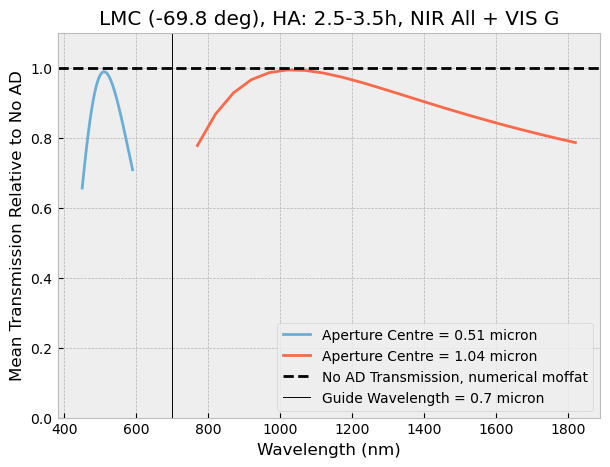

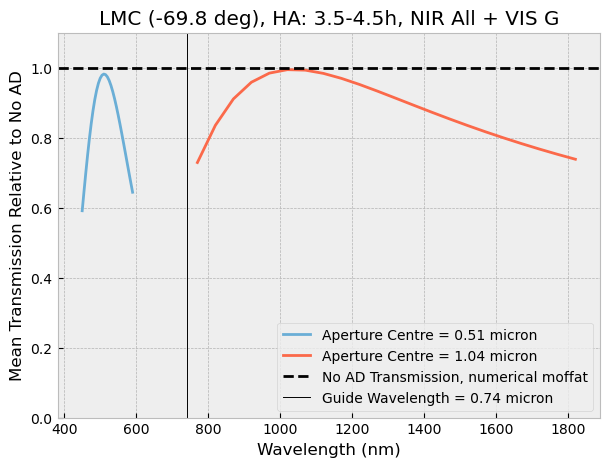

In [71]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[4]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("LMC ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))

    int_analysis.track_plot(analysis,"mid HA")

0.68 micron [0.51] micron [1.04] micron
[[0.7079201138176173, 0.9920963772192838, 0.9004115457780054]]
[[0.8148722533139094, 0.9935985320055154, 0.9202498375339173]]
0.68 micron [0.51] micron [1.04] micron
[[0.6991562785702148, 0.9918481990229827, 0.896941464562844]]
[[0.808578951838962, 0.9933914813728874, 0.9173648978923507]]
0.69 micron [0.51] micron [1.04] micron
[[0.6727254818422632, 0.9904063466169837, 0.8859170428846259]]
[[0.7899722190153301, 0.9934066844628033, 0.9093618270880076]]
0.72 micron [0.51] micron [1.04] micron
[[0.6296383818970003, 0.9866200445353194, 0.8664466233583543]]
[[0.7593507159135894, 0.9942365338910631, 0.8966479827043824]]
0.7 micron [0.51] micron [1.05] micron
[[0.5755965321817089, 0.9853872189942735, 0.8425614195269377]]
[[0.7051527046850274, 0.9905650489011395, 0.8788545545050148]]


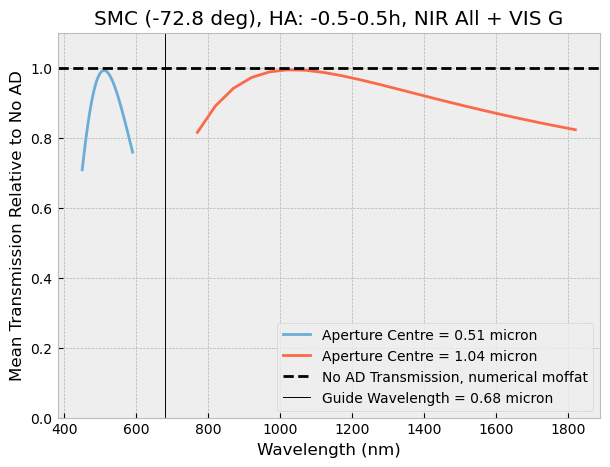

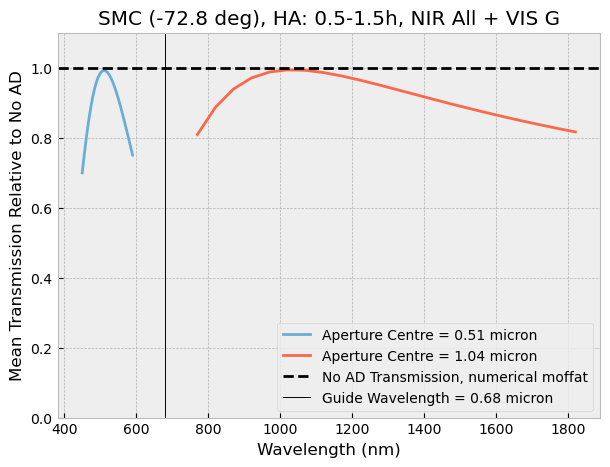

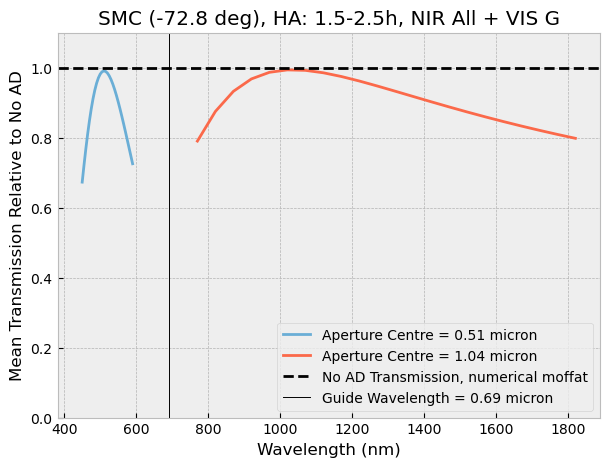

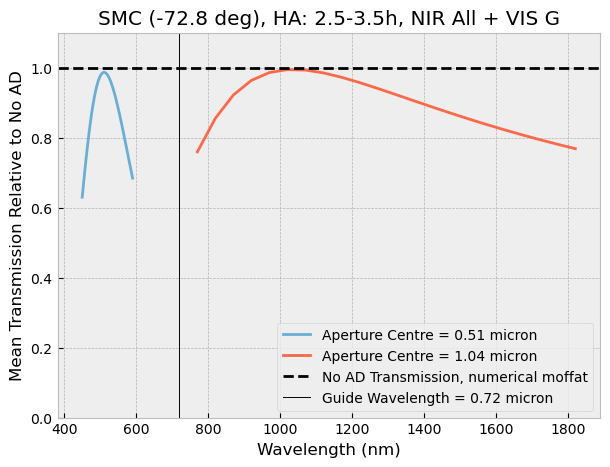

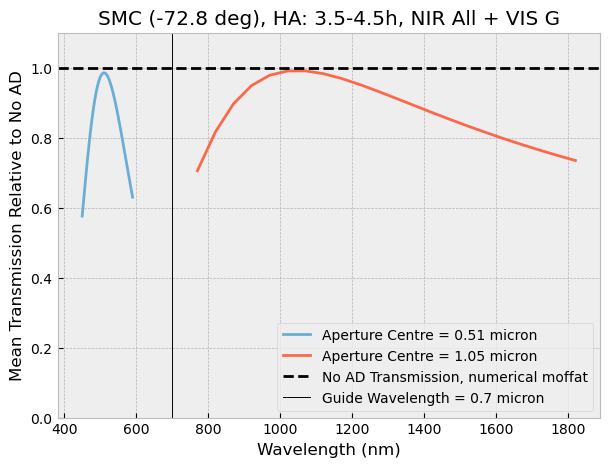

In [72]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[5]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.6,.8,.01)*u.micron,np.arange(.48,.53,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'V',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"V",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("SMC ({}), HA: {}-{}h, NIR All + VIS G".format(targ_dec,HA_range[0],HA_range[-1]))

    int_analysis.track_plot(analysis,"mid HA")